In [3]:
from constraints import *
from helper import *

# Lotka Volterra

Lotka Volterra (discretized) dynamics:

$x_{t+1} = (a - by_t - \lambda x_t)x_t \Delta_t + x_t $         
$y_{t+1} = (cx_t - d - \mu y_t)y_t \Delta_t + y_t $

$a,b,c,d,\lambda,\mu > 0 $

### Forward Euler for Lotka Volterra

In [4]:
def forwardEulerLV(init,constants,plot=False):
    x0, y0 = init[0], init[1]
    T = constants["T"]
    a, b, lamb, c, d, mu, del_t = constants["a"], constants["b"], constants["lambda"], constants["c"], constants["d"], constants["mu"], constants["del_t"]
    
    xs, ys = [x0], [y0]
    x,y = x0, y0
    for t in range(T):
        x, y = (a-b*y-lamb*x)*x*del_t + x, (c*x-d-mu*y)*y*del_t + y
        xs.append(x)
        ys.append(y)
        
    if plot:
        plt.figure()
        plt.plot(xs, ys, '*')
        
    traj = [(xs[i],ys[i]) for i in range(len(xs))]
    return traj

### Initial Setup

In [5]:
# horizon and forward Euler time step
T = 5
del_t = 0.1

# box constraints for initial state
x0 = 1
y0 = 1
x_dev = 0.1
y_dev = 0.1

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0

# constants for dynamics
constants = {"a":1, "b":1, "lambda":1, 
             "c":1, "d":1, "mu":1, 
             "T":T, "del_t":del_t,
             "x0":x0, "y0":y0}

x_range, y_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev]

### Fast Reachable Set Computation

In [6]:
areas_fast = []
times_fast = []
boxes_fast = []

x0_bounds = BoxConstraints(x_lw_b,x_up_b)
y0_bounds = BoxConstraints(y_lw_b,y_up_b)
var_bounds = {"x":x0_bounds, "y":y0_bounds}

x_0_coeffs = {"x":1, "y":0, "_const":0}
x_0 = LinearConstraints(Line(x_0_coeffs.copy()), Line(x_0_coeffs.copy()),var_bounds)

y_0_coeffs = {"x":0, "y":1, "_const":0}
y_0 = LinearConstraints(Line(y_0_coeffs.copy()), Line(y_0_coeffs.copy()),var_bounds)

# k_0 = a - by_t - \lambda x_t
k_0_coeffs = {"x":-1*constants["lambda"], "y":-1*constants["b"], "_const":constants["a"]}
k_0 = LinearConstraints(Line(k_0_coeffs.copy()), Line(k_0_coeffs.copy()),var_bounds)

l_0_coeffs = {"x":constants["c"], "y":-1*constants["mu"], "_const":-1*constants["d"]}
l_0 = LinearConstraints(Line(l_0_coeffs.copy()), Line(l_0_coeffs.copy()),var_bounds)

for t in range(constants["T"]):
    tt = time.time()
    box_x, box_y = x_0.eval_box(), y_0.eval_box()
    areas_fast.append((box_x.upper-box_x.lower)*(box_y.upper-box_y.lower))
    boxes_fast.append(([box_x.lower,box_x.upper],[box_y.lower,box_y.upper]))
    if t > 0:
        k_0 = x_0.mult_const(-1*constants["lambda"]).add(y_0.mult_const(-1*constants["b"]).add_const(constants["a"]))
        l_0 = x_0.mult_const(constants["c"]).add(y_0.mult_const(-1*constants["mu"]).add_const(-1*constants["d"]))

    m_0 = k_0.mult(x_0)
    m_0 = m_0.mult_const(constants["del_t"]).add(x_0)

    n_0 = l_0.mult(y_0)
    n_0 = n_0.mult_const(constants["del_t"]).add(y_0)
    
    x_0, y_0 = m_0, n_0
    
    tt = time.time() - tt
    times_fast.append(tt)
    
    x_final, y_final = x_0, y_0

### CVX Reachable Set Computation

In [7]:
def lotkaVolterraConstraints(T=1,variables=[],constants={},constraints=[],control_bounds=[],Npast=0,plot=False):
    times = []
    T = constants["T"]
    areas = []
    boxes = []
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)
        xL,xU = x_bounds
        yL,yU = y_bounds
        
        boxes.append(([xL,xU],[yL,yU]))
        areas.append((xU-xL)*(yU-yL))
        ######### lil plot
        if plot:
    #         clear_output(wait=True)
            fig = plt.figure(1)
            if t>0: 
                #plt.clf()
                plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')
                plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'k')
                # print("x_b: ",x_bounds)
                # print("y_b: ",y_bounds)
            fig.canvas.draw()   # draw
            plt.pause(1.01)
        ########
        
        a, b, lamb, c, d, mu, del_t = constants["a"], constants["b"], constants["lambda"], constants["c"], constants["d"], constants["mu"], constants["del_t"]
 
        k_1 = variables[t]["k_1"]
        constraints.append(k_1 == (a - b*y - lamb*x)*del_t)
        k_1_bounds = bounds(k_1,constraints,Npast=Npast)
        
        l_1 = variables[t]["l_1"]
        constraints.extend(McCormick(l_1,k_1,x,k_1_bounds,x_bounds))
        
        k_2 = variables[t]["k_2"]
        constraints.append(k_2 == (c*x - d - mu*y)*del_t)
        k_2_bounds = bounds(k_2,constraints,Npast=Npast)
        
        l_2 = variables[t]["l_2"]
        constraints.extend(McCormick(l_2,k_2,y,k_2_bounds,y_bounds))
        
        x_new = variables[t+1]["x"]
        constraints.append(x_new == l_1 + x)
        
        y_new = variables[t+1]["y"]
        constraints.append(y_new == l_2 + y)

        tt = time.time() - tt
        times.append(tt)
#         print("Time for ",t,"-th loop: ",tt)

    # plt.figure(2)
    # plt.plot(times,'r*')
    if plot:
        xs,ys = forwardEulerLV(constants["x0"],constants["y0"],constants,plot=False)
        plt.plot(xs, ys, '*')
        plt.show()
    
    return variables,constraints,times,areas,boxes

In [8]:
variables = [{"x":cvxpy.Variable(),"y":cvxpy.Variable(),"k_1":cvxpy.Variable(),"k_2":cvxpy.Variable(),"l_1":cvxpy.Variable(),"l_2":cvxpy.Variable()} for t in range(T+1)]

x = variables[0]["x"]
y = variables[0]["y"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)

variables,constraints,times_convex,areas_convex,boxes_convex = lotkaVolterraConstraints(T,variables,constants,constraints)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)

### Visualizations

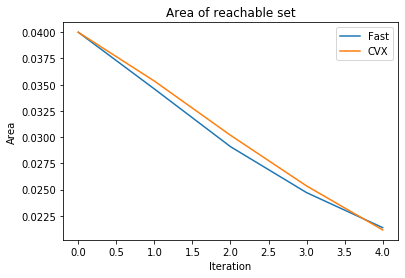

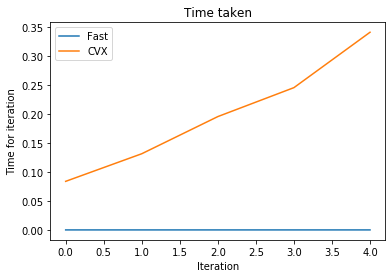

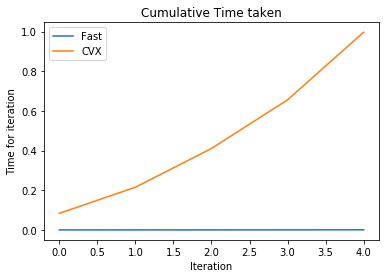

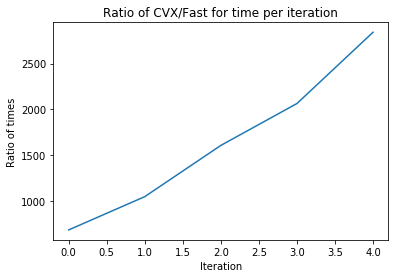

In [9]:
convex_res = {"area":areas_convex, "time":times_convex}
fast_res = {"area":areas_fast, "time":times_fast}
visualize(convex_res,fast_res)

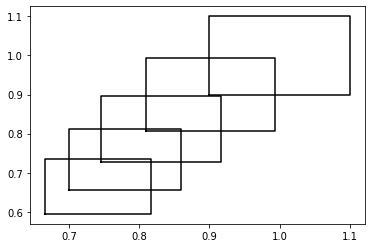

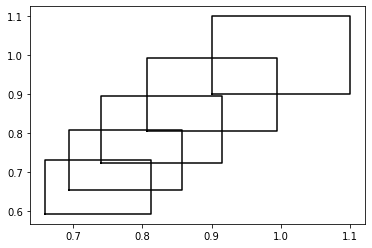

In [10]:
plot_boxes_2d(boxes_fast)
plot_boxes_2d(boxes_convex)

In [9]:
boxes_fast

[([0.99, 1.01], [0.99, 1.01]),
 ([0.891, 0.9090399999999998], [0.891, 0.90904]),
 ([0.8198928540000001, 0.8361791179199999],
  [0.8020764180000001, 0.8180035537599998]),
 ([0.7678403583142461, 0.782604793030824],
  [0.7235442638036752, 0.7374924505370247]),
 ([0.7293098586713447, 0.7427662065270803],
  [0.6546608642663049, 0.6668594110873706])]

### Verify Boxes Found are Valid via Sampling

Sample the space of initial conditions and forward propogate trajectories using the forward Euler method to validate if trajectories remain within boxed sets found via both the CVX approach or the fast approach.

False
True


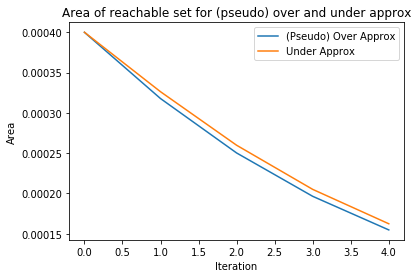

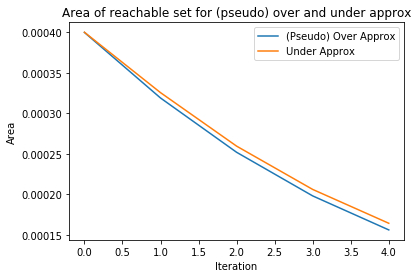

In [16]:
num_samples = 10000
print(verify_valid_boxes(boxes_convex,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerLV,constants=constants))
print(verify_valid_boxes(boxes_fast,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerLV,constants=constants))